In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.linalg import eigh, LinAlgError

In [2]:
import torchaudio.transforms
import torch

In [3]:
### Loading data
noise_mask_0 = np.load('../model_results/model_output/noise_mask_mic0.npy')
target_mask_0 = np.load('../model_results/model_output/target_mask_mic0.npy')
noise_mask_1 = np.load('../model_results/model_output/noise_mask_mic1.npy')
target_mask_1 = np.load('../model_results/model_output/target_mask_mic1.npy')

#pred_spec_1_imag = np.load('../model_results/model_output/pred_spec_1_imag.npy')
#pred_spec_1_real = np.load('../model_results/model_output/pred_spec_1_real.npy')
#pred_spec_2_imag = np.load('../model_results/model_output/pred_spec_2_imag.npy')
#pred_spec_2_real = np.load('../model_results/model_output/pred_spec_2_real.npy')

mixture_spec_mic0 = np.load('../model_results/model_output/mixture_spec_mic0.npy')
mixture_spec_mic0 = mixture_spec_mic0[:,:256,:]
mixture_spec_mic1 = np.load('../model_results/model_output/mixture_spec_mic1.npy')
mixture_spec_mic1 = mixture_spec_mic1[:,:256,:]


In [4]:
# Print the shapes of the arrays
print(f"Shape of target_mask_0: {target_mask_0.shape}")
print(f"Shape of noise_mask_0: {noise_mask_0.shape}")
print(f"Shape of target_mask_1: {target_mask_1.shape}")
print(f"Shape of noise_mask_1: {noise_mask_1.shape}")

print(f"Shape of mixture_spec_mic0: {mixture_spec_mic0.shape}")
print(f"Shape of mixture_spec_mic1: {mixture_spec_mic1.shape}")

# If you want to see basic stats about the masks, you can do the following:
#print(f"Target Mask - Min: {np.min(target_mask)}, Max: {np.max(target_mask)}, Mean: {np.mean(target_mask)}, Std: {np.std(target_mask)}")
#print(f"Noise Mask - Min: {np.min(noise_mask)}, Max: {np.max(noise_mask)}, Mean: {np.mean(noise_mask)}, Std: {np.std(noise_mask)}")


Shape of target_mask_0: (1, 2, 256, 256)
Shape of noise_mask_0: (1, 2, 256, 256)
Shape of target_mask_1: (1, 2, 256, 256)
Shape of noise_mask_1: (1, 2, 256, 256)
Shape of mixture_spec_mic0: (2, 256, 256)
Shape of mixture_spec_mic1: (2, 256, 256)


In [5]:
#Prepare data for PSD calculation
# Convert to PyTorch tensors
mixture_spec_mic0_tensor = torch.from_numpy(mixture_spec_mic0)
mixture_spec_mic1_tensor = torch.from_numpy(mixture_spec_mic1)
#target_mask_0_tensor = target_mask_0_tensor[:,:,-1,:]
#target_mask_1_tensor = target_mask_1_tensor[:,:,-1,:]
target_mask_0_tensor = torch.from_numpy(target_mask_0)
target_mask_1_tensor = torch.from_numpy(target_mask_1)

noise_mask_0_tensor = torch.from_numpy(noise_mask_0)
noise_mask_1_tensor = torch.from_numpy(noise_mask_1)

spectrogram_tensor = torch.stack([mixture_spec_mic0_tensor, mixture_spec_mic1_tensor], dim=0)
target_mask_tensor = torch.stack([target_mask_0_tensor,target_mask_1_tensor], dim=0) 
target_mask_tensor = target_mask_tensor[:,0,:,:,:]
noise_mask_tensor = torch.stack([noise_mask_0_tensor,noise_mask_1_tensor], dim=0) 
noise_mask_tensor = noise_mask_tensor[:,0,:,:,:]
 

In [6]:
print(f"Shape of spectrogram_tensor: {spectrogram_tensor.shape}")
print(f"Shape of target_mask_tensor: {target_mask_tensor.shape}")
print(f"Shape of target_mask_tensor: {noise_mask_tensor.shape}")
print (spectrogram_tensor.dtype)

Shape of spectrogram_tensor: torch.Size([2, 2, 256, 256])
Shape of target_mask_tensor: torch.Size([2, 2, 256, 256])
Shape of target_mask_tensor: torch.Size([2, 2, 256, 256])
torch.float64


In [7]:
#Compute PSD Matrices
psd_transform = torchaudio.transforms.PSD(multi_mask=True)

In [8]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)


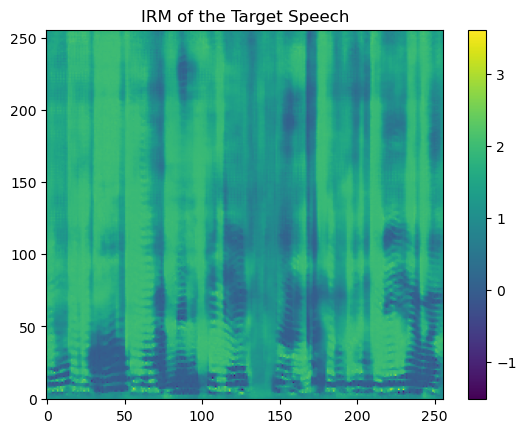

In [9]:
plot_mask(target_mask_0_tensor[0,0,:,:], "IRM of the Target Speech")

In [10]:
psd_matrix_target = psd_transform(spectrogram_tensor.unsqueeze(0), target_mask_tensor.unsqueeze(0))
print (psd_matrix_target[0,0].shape)
#psd_matrix_target = psd_matrix_target.squeeze(0)
psd_matrix_noise = psd_transform(spectrogram_tensor.unsqueeze(0), noise_mask_tensor.unsqueeze(0))
#psd_matrix_noise = psd_matrix_noise.squeeze(0)
print(f"Shape of psd_matrix_target: {psd_matrix_target.shape}")
print(f"Shape of psd_matrix_noise: {psd_matrix_noise.shape}")


torch.Size([256, 2, 2])
Shape of psd_matrix_target: torch.Size([1, 2, 256, 2, 2])
Shape of psd_matrix_noise: torch.Size([1, 2, 256, 2, 2])


In [11]:

#istft = torchaudio.transforms.InverseSpectrogram(n_fft=510, win_length=400, hop_length=160)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=510, win_length=400, hop_length=160)
psd_matrix_target = psd_matrix_target.to(torch.cdouble)
psd_matrix_noise = psd_matrix_noise.to(torch.cdouble)
spectrogram_tensor = spectrogram_tensor.to(torch.cdouble)
print (psd_matrix_noise.shape)

torch.Size([1, 2, 256, 2, 2])


In [12]:
def istft_reconstruction(mag, phase, hop_length=160, win_length=400, length=65535):
    spec = mag.astype(np.complex128) * np.exp(1j*phase)
    wav = librosa.istft(spec, hop_length=hop_length, win_length=win_length, length=length)
    return np.clip(wav, -1., 1.)

In [13]:
def istft_reconstruction_torch(complex_spec, hop_length=160, win_length=400, length=65535):
    # Create a complex spectrum from magnitude and phase
 # This is more direct for mag/phase to complex

    # Perform ISTFT using PyTorch
    wav_tensor = librosa.istft(complex_spec.unsqueeze(0),  # Add batch dimension
                             n_fft=win_length,           # Window length for the FFT
                             hop_length=hop_length,
                             win_length=win_length,
                             length=length)

    return wav_tensor

In [14]:
import torchaudio.functional as F
rtf_evd = F.rtf_evd(psd_matrix_target)  

In [15]:
rtf_evd_numpy = rtf_evd.cpu().detach().numpy()
print(f"Shape of rtf_evd: {rtf_evd_numpy.shape}")

Shape of rtf_evd: (1, 2, 256, 2)


In [16]:
from signal_processing import audiowrite, stft, istft
from IPython.display import Audio

In [17]:
magnitude = rtf_evd[0, 0, :, :]
print (f'Shape of magnitude vector: {magnitude.shape}')
phase = rtf_evd[0, 1, :, :]
wav =istft_reconstruction_torch(rtf_evd[0,0,:,:], hop_length=160, win_length=400, length=65535)

Shape of magnitude vector: torch.Size([256, 2])


TypeError: Cannot interpret 'torch.complex128' as a data type

In [18]:
magnitude = rtf_evd[0, 0, :, :]
print (f'Shape of magnitude vector: {magnitude.shape}')
phase = rtf_evd[0, 1, :, :]
wav =istft_reconstruction(rtf_evd_numpy[0],rtf_evd_numpy[0,1, :, :],hop_length=160, win_length=400, length=65535)

Shape of magnitude vector: torch.Size([256, 2])


In [19]:
print (f'Shape of wav file: {wav.shape}')
# Play the audio
display(Audio(wav, rate=16000))  # Replace 16000 with your sample rate

Shape of wav file: (2, 65535)


In [20]:
#print(f"Shape of psd_matrix_target: {psd_matrix_target.shape}")
print(f"Shape of psd_matrix_noise: {psd_matrix_noise[0,0].shape}")
print(f"Shape of rtf_evd: {rtf_evd[0,0].shape}")
print(f"Shape of spectrogram_tensor: {spectrogram_tensor[0].shape}")

Shape of psd_matrix_noise: torch.Size([256, 2, 2])
Shape of rtf_evd: torch.Size([256, 2])
Shape of spectrogram_tensor: torch.Size([2, 256, 256])


In [21]:
mvdr_transform = torchaudio.transforms.RTFMVDR()
REFERENCE_CHANNEL = 0
# compute the enhanced speech based on F.rtf_evd
stft_rtf_evd = mvdr_transform(spectrogram_tensor[0], rtf_evd[0,0], psd_matrix_noise[0,0], reference_channel=REFERENCE_CHANNEL)
#stft_rtf_evd=stft_rtf_evd.to(torch.float64)
print (f'Shape of stft_rtf_evd : {stft_rtf_evd.shape}')

Shape of stft_rtf_evd : torch.Size([256, 256])


In [22]:
print(f"Shape of stft_rtf_evd: {stft_rtf_evd.shape}")

Shape of stft_rtf_evd: torch.Size([256, 256])


In [23]:
# Assuming psd_matrix_noise is the input for ISTFT
print(f"Shape before ISTFT: {psd_matrix_noise.shape}, dtype: {psd_matrix_noise.dtype}")
waveform_rtf_evd = istft(stft_rtf_evd, length=65535)

Shape before ISTFT: torch.Size([1, 2, 256, 2, 2]), dtype: torch.complex128


TypeError: istft() got an unexpected keyword argument 'length'

In [24]:
from pprint import pprint 
print(f'Shape of the GEV Vector is: {rtf_evd.shape}')
pprint(f'Shape of the GEV Vector is: {rtf_evd[:10, :10, 0]}')

Shape of the GEV Vector is: torch.Size([1, 2, 256, 2])
('Shape of the GEV Vector is: tensor([[[1.+0.j, 0.+0.j],\n'
 '         [1.+0.j, 0.+0.j]]], dtype=torch.complex128)')


In [25]:
256*2+1

513

In [26]:
#Back to numpy 
spectrogram_array = spectrogram_tensor.detach().cpu().numpy()
target_mask_array = target_mask_tensor.detach().cpu().numpy()
noise_mask_array = noise_mask_tensor.detach().cpu().numpy()
psd_matrix_noise = psd_matrix_noise.detach().cpu().numpy()
psd_matrix_target = psd_matrix_target.detach().cpu().numpy()

In [27]:
print(f"Shape of psd_matrix_target: {psd_matrix_target.shape}")
print(f"Shape of psd_matrix_noise: {psd_matrix_noise.shape}")
print (spectrogram_array.dtype)

Shape of psd_matrix_target: (1, 2, 256, 2, 2)
Shape of psd_matrix_noise: (1, 2, 256, 2, 2)
complex128


In [28]:
class GEVBeamformer:
    def __init__(self, gamma=1e-6):
        self.gamma = gamma
        
    def condition_covariance(self, x, gamma):
        
        """see https://stt.msu.edu/users/mauryaas/Ashwini_JPEN.pdf (2.3)"""
        
        scale = gamma * np.trace(x) / x.shape[-1]
        scaled_eye = np.eye(x.shape[-1]) * scale
        return (x + scaled_eye) / (1 + gamma)
    
    def phase_correction(self, vector):
        """Phase correction to reduce distortions due to phase inconsistencies
        Args:
        vector: Beamforming vector with shape (..., bins, sensors).
        Returns: Phase corrected beamforming vectors. Lengths remain.
        """
        
        w = vector.copy()
        F, D = w.shape
        for f in range(1, F):
            w[f, :] *= np.exp(-1j*np.angle(
                np.sum(w[f, :] * w[f-1, :].conj(), axis=-1, keepdims=True)))
        return w
    
    def get_gev_vector(self, target_psd_matrix, noise_psd_matrix):
        
        """
        Returns the GEV beamforming vector.
        :param target_psd_matrix: Target PSD matrix
        with shape (bins, sensors, sensors)
        :param noise_psd_matrix: Noise PSD matrix
        with shape (bins, sensors, sensors)
        :return: Set of beamforming vectors with shape (bins, sensors)
        """
        #target_psd_matrix = target_psd_matrix[0,:,:,:]
        target_psd_matrix = target_psd_matrix[0,0]
        print(target_psd_matrix.shape)
        #noise_psd_matrix = noise_psd_matrix[0,:,:,:]
        noise_psd_matrix = noise_psd_matrix[0,0]
        bins, sensors, _ = target_psd_matrix.shape
        beamforming_vector = np.empty((bins, sensors), dtype=np.complex128)
        for f in range(bins):
            try:
                eigenvals, eigenvecs = eigh(target_psd_matrix[f, :, :],
                                        noise_psd_matrix[f, :, :])
                beamforming_vector[f, :] = eigenvecs[:, -1]
            except np.linalg.LinAlgError:
                print('LinAlg error for frequency {}'.format(f))
                beamforming_vector[f, :] = (
                    np.ones((sensors,)) / np.trace(noise_psd_matrix[f]) * sensors)
        return beamforming_vector


    def get_beamforming_vector(self, target_psd_matrix, noise_psd_matrix):
        # First, condition the noise PSD matrix
        conditioned_noise_psd = self.condition_covariance(noise_psd_matrix)
        # Then, get the GEV beamforming vector
        return get_gev_vector(target_psd_matrix, conditioned_noise_psd)
    
    def apply_beamforming_vector(self, vector, mix):
        return np.einsum('...a,...at->...t', vector.conj(), mix)
    
    def gev_wrapper_on_masks(self, mix, target_psd_matrix, noise_psd_matrix,
                         normalization=False):
        org_dtype = mix.dtype
        mix = mix.astype(np.complex128)
        mix = mix.T
        noise_psd_matrix = self.condition_covariance(noise_psd_matrix, 1e-6)
        noise_psd_matrix /= np.trace(
            noise_psd_matrix, axis1=-2, axis2=-1)[..., None, None]
        W_gev = self.get_gev_vector(target_psd_matrix, noise_psd_matrix)
        print (f'Shape of GEV vector: {W_gev.shape}')
        W_gev = self.phase_correction(W_gev)
        print (f'Shape of GEV vector: {W_gev.shape}')
        if normalization:
            W_gev = blind_analytic_normalization(W_gev, noise_psd_matrix)
        print (f'Shape of GEV vector: {W_gev.shape}')
        output = self.apply_beamforming_vector(W_gev, mix)
        print (f'Shape of GEV vector: {output.shape}')
        #output = output.astype(org_dtype)
        print (f'Shape of GEV vector: {output.shape}')
        return output.T
   

In [29]:
#apply Beamforming
print (spectrogram_array.dtype)
gev_beamformer = GEVBeamformer()
gev = gev_beamformer.gev_wrapper_on_masks(spectrogram_array, 
                         psd_matrix_target, 
                         psd_matrix_noise)

complex128
(256, 2, 2)
LinAlg error for frequency 0
Shape of GEV vector: (256, 2)
Shape of GEV vector: (256, 2)
Shape of GEV vector: (256, 2)
Shape of GEV vector: (256, 256, 2)
Shape of GEV vector: (256, 256, 2)


In [30]:
y, sr = librosa.load("C:/Users/yosra/Documents/AV-speech-separation/data/simulated_RIR/VoxCeleb2/raw_audio/id04030/JbcD0P6KGe0/00039_mic0_voice0.wav", sr=16000)  # sr=None ensures the original sampling rate is used

# Calculate the duration in seconds
duration = librosa.get_duration(y=y, sr=sr)
context_samples = duration * 16000

In [31]:
def istft_reconstruction(mag, phase, hop_length=160, win_length=400, length=65535):
    spec = mag.astype(np.complex128) * np.exp(1j*phase)
    wav = librosa.istft(spec, hop_length=hop_length, win_length=win_length, length=length)
    return np.clip(wav, -1., 1.)

In [32]:
print(gev.shape)
magnitude = gev[0,:,:]
print (f'Shape of magnitude vector: {magnitude.shape}')
phase = gev[1,:,:]
wav =istft_reconstruction(magnitude, phase, hop_length=160, win_length=400, length=65535)
print (wav.shape)

(2, 256, 256)
Shape of magnitude vector: (256, 256)
(65535,)


In [33]:
print(f'The GEV vector type is: {gev.dtype}')
print(f'The GEV vector shape is: {gev.shape}')
phase = spectrogram_array[1,:,:,:]
print(f'The phase shape is: {phase.shape}')
#wav =istft_reconstruction(gev[:,0], gev[:,1], hop_length=160, win_length=400, length=65535)
wav =istft_reconstruction(gev, phase, hop_length=160, win_length=400, length=65535)
#time_signal = istft(gev, size=512, shift=128, window_length=400)
filename = 'ay_rabi_m3ak.wav'
# Write the audio data to a WAV file
#audiowrite(audio_time_domain, filename, 16000, True, True)

The GEV vector type is: complex128
The GEV vector shape is: (2, 256, 256)
The phase shape is: (2, 256, 256)


ParameterError: Target size (2) must be at least input size (400)

In [40]:
# Play the audio
display(Audio(wav, rate=16000))  # Replace 16000 with your sample rate

In [36]:
def plot_waveform(waveform=None, sampling_rate=16000, title="Waveform Plot", x_label="Time (s)", y_label="Amplitude", theme="light"):
    """
    Plots a waveform with customization options.

    Parameters:
    - waveform: ndarray, optional
        The waveform data to plot. If None, a default sine wave is generated.
    - sampling_rate: int, optional
        The sampling rate of the waveform in Hz.
    - title: str, optional
        The title of the plot.
    - x_label: str, optional
        The label for the x-axis.
    - y_label: str, optional
        The label for the y-axis.
    - theme: str, optional
        The theme of the plot, "light" or "dark".

    Returns:
    - None
    """

    # Create a default sine waveform if none is provided
    if waveform is None:
        t = np.linspace(0, 1, sampling_rate)
        waveform = np.sin(2 * np.pi * 5 * t)  # 5 Hz sine wave
    else:
        t = np.arange(len(waveform)) / sampling_rate

    # Set theme
    if theme == "dark":
        plt.style.use("dark_background")
    else:
        plt.style.use("seaborn-whitegrid")

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(t, waveform, linewidth=2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [37]:
print (f'the shape of the wavefile is the following: {wav.shape}')

the shape of the wavefile is the following: (65535,)


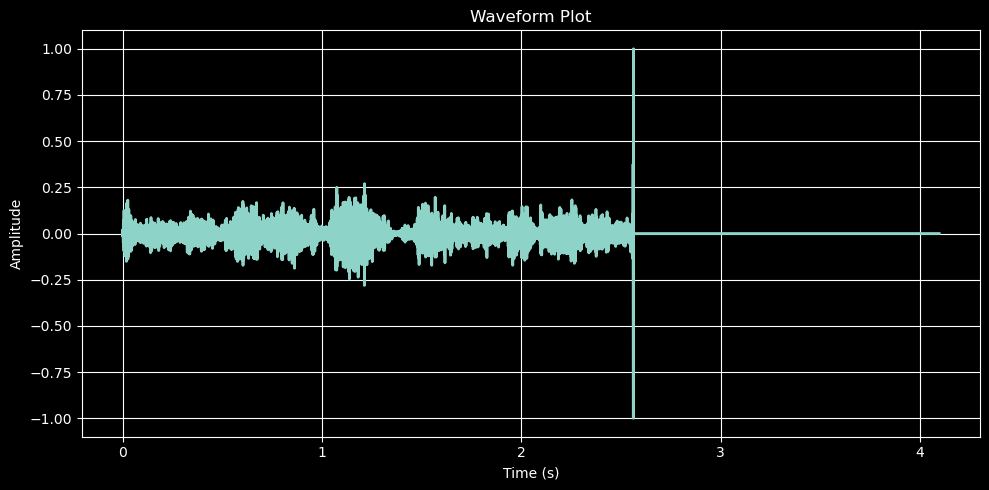

In [39]:
plot_waveform(waveform=wav, sampling_rate=16000, title="Waveform Plot", x_label="Time (s)", y_label="Amplitude", theme="dark")

In [43]:
import wave
from scipy.io import wavfile
def save_multichannel_wav(channels, filename, framerate=16000, sampwidth=4):
    """
    Saves multiple audio channels to a single multi-channel WAV file.
    
    Parameters:
        channels (list of np.array): List containing audio data for each channel.
        filename (str): Path and name of the output WAV file.
        framerate (int): Frame rate in Hz (default is 44100 Hz).
        sampwidth (int): Sample width in bytes (default for np.float32 is 4 bytes).
    """
    # Check that all channels have the same length
    if not all(len(channel) == len(channels[0]) for channel in channels):
        raise ValueError("All channels must have the same length")

    # Interleave channel data
    interleaved = np.vstack(channels).reshape((-1,), order='F')

    # Open file and set parameters
    with wave.open(filename, 'w') as wav_file:
        wav_file.setnchannels(len(channels))
        wav_file.setsampwidth(sampwidth)
        wav_file.setframerate(framerate)
        wav_file.setnframes(len(interleaved))

        # Write frames as bytes
        wav_file.writeframes(interleaved.astype(np.float32).tobytes())
    return interleaved.astype(np.float32)


In [51]:
channels = []
sample_rate, wav1 = wavfile.read("../test/id04030_JbcD0P6KGe0_00039VSid08696_f0gzvkyroAY_00388/00039_mic0.wav")
print(wav1.shape)
channels.append(wav1)
print(channels)
sample_rate, wav2 = wavfile.read("../test/id04030_JbcD0P6KGe0_00039VSid08696_f0gzvkyroAY_00388/00039_mic1.wav") 
channels.append(wav2)

(64512,)
[array([-3, -5, -7, ..., 57, 47, 33], dtype=int16)]


In [54]:


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()
def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [56]:
wav_clean = save_multichannel_wav(channels, 'multi.wav')
print (wav.shape)
print (wav_clean.shape)
evaluate(wav, wav_clean)


(65535,)
(129024,)


AttributeError: 'numpy.ndarray' object has no attribute 'pow'

In [57]:
# Play the audio
display(Audio(wav_clean, rate=16000))  # Replace 16000 with your sample rate